In [127]:
from pathlib import Path
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="dark")
sns.set_context("talk")

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import category_encoders as ce

In [3]:
data = pd.read_csv('depression_data.csv')
data.columns = data.columns.str.replace(' ', '_').str.lower()

In [4]:
data.head()

,name,age,marital_status,education_level,number_of_children,smoking_status,physical_activity_level,employment_status,income,alcohol_consumption,dietary_habits,sleep_patterns,history_of_mental_illness,history_of_substance_abuse,family_history_of_depression,chronic_medical_conditions
0,Christine Barker,31,Married,Bachelor's Degree,2,Non-smoker,Active,Unemployed,26265.67,Moderate,Moderate,Fair,Yes,No,Yes,Yes
1,Jacqueline Lewis,55,Married,High School,1,Non-smoker,Sedentary,Employed,42710.36,High,Unhealthy,Fair,Yes,No,No,Yes
2,Shannon Church,78,Widowed,Master's Degree,1,Non-smoker,Sedentary,Employed,125332.79,Low,Unhealthy,Good,No,No,Yes,No
3,Charles Jordan,58,Divorced,Master's Degree,3,Non-smoker,Moderate,Unemployed,9992.78,Moderate,Moderate,Poor,No,No,No,No
4,Michael Rich,18,Single,High School,0,Non-smoker,Sedentary,Unemployed,8595.08,Low,Moderate,Fair,Yes,No,Yes,Yes


In [5]:
data.describe()
# no clear outliers in data

,age,number_of_children,income
count,413768.000000,413768.000000,413768.000000
mean,49.000713,1.298972,50661.707971
std,18.158759,1.237054,40624.100565
min,18.000000,0.000000,0.410000
25%,33.000000,0.000000,21001.030000
50%,49.000000,1.000000,37520.135000
75%,65.000000,2.000000,76616.300000
max,80.000000,4.000000,209995.220000


In [6]:
data.info()
# no noticeable nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413768 entries, 0 to 413767
Data columns (total 16 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   name                          413768 non-null  object 
 1   age                           413768 non-null  int64  
 2   marital_status                413768 non-null  object 
 3   education_level               413768 non-null  object 
 4   number_of_children            413768 non-null  int64  
 5   smoking_status                413768 non-null  object 
 6   physical_activity_level       413768 non-null  object 
 7   employment_status             413768 non-null  object 
 8   income                        413768 non-null  float64
 9   alcohol_consumption           413768 non-null  object 
 10  dietary_habits                413768 non-null  object 
 11  sleep_patterns                413768 non-null  object 
 12  history_of_mental_illness     413768 non-nul

## Exploratory analysis

In [7]:
data["mental_illness"] = np.where(data["history_of_mental_illness"] == "Yes", 1, 0)

In [8]:
# overall rate is 30%
data["history_of_mental_illness"].value_counts(normalize=True)

No     0.695904
Yes    0.304096
Name: history_of_mental_illness, dtype: float64

In [118]:
def categorical_plot(col):
    df = data.groupby(col).agg(
    **{
        "count": (col, "count"),
        "mental_illness": ("mental_illness", "mean")
    }
    ).reset_index()

    fig, ax1 = plt.subplots(figsize=(7,5))
    ax2 = ax1.twinx()
    ax1.bar(df[col], df["count"])
    ax2.plot(df[col], df["mental_illness"], 'o-', color="red" )
    
    ax1.set_xlabel(col)
    ax1.set_ylabel('Count', color="blue")
    ax2.set_ylabel('mental_illnes_rate', color='red')
    ax2.set_ylim(0.2,0.4)
    ax1.tick_params(axis='x', labelrotation=45)

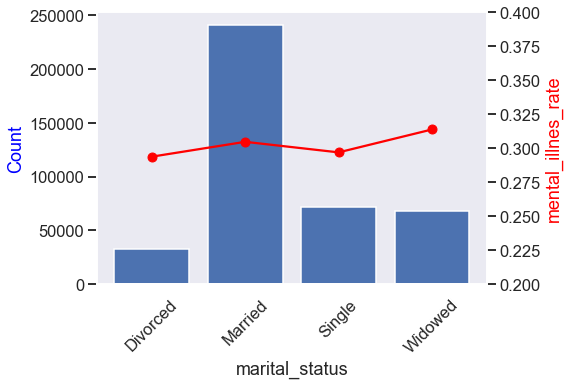

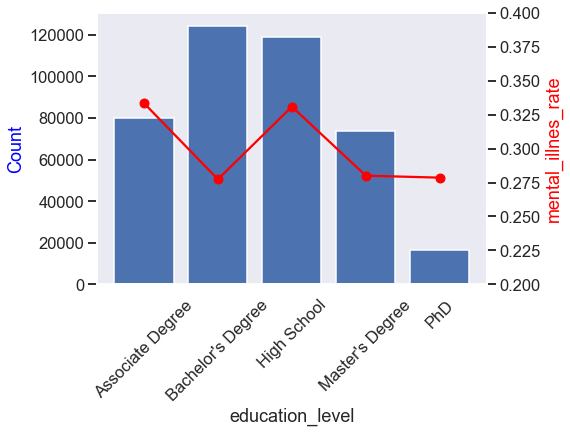

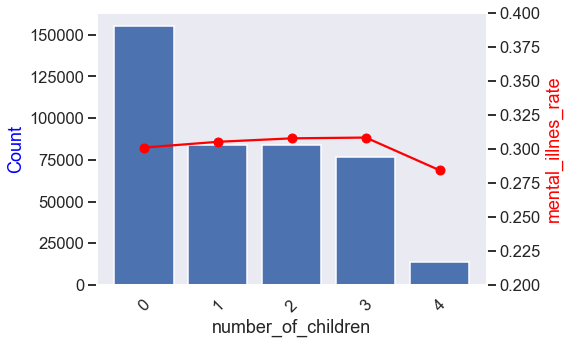

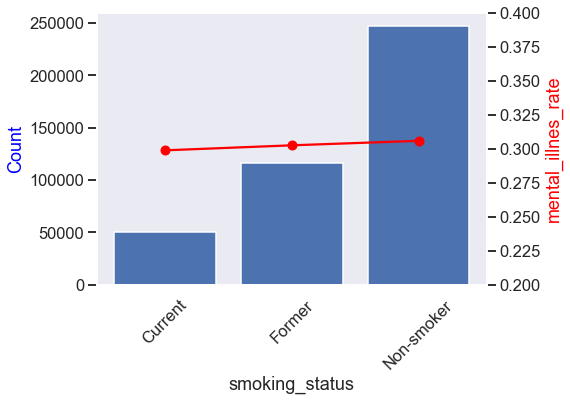

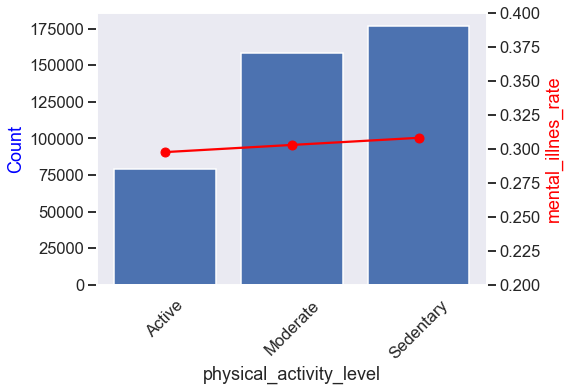

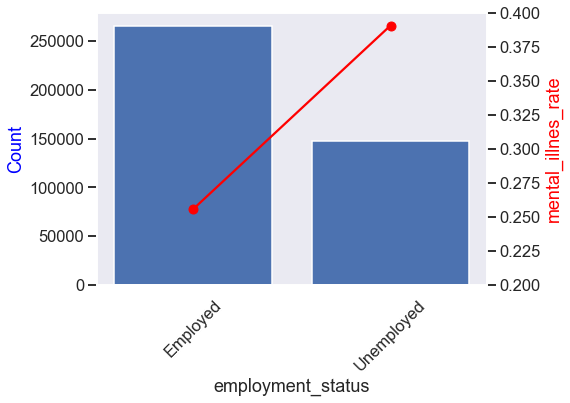

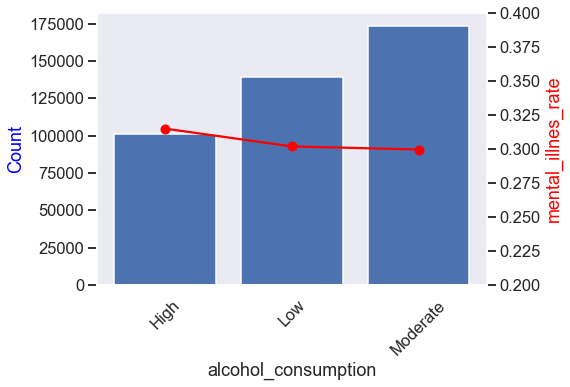

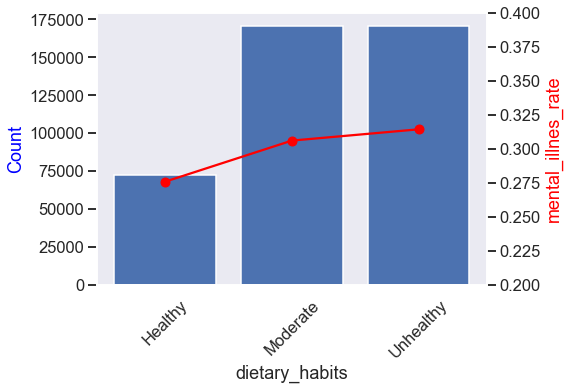

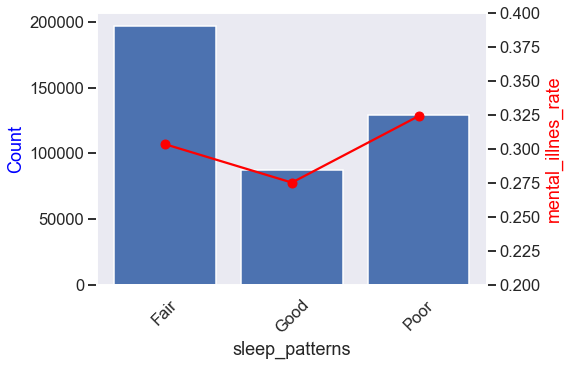

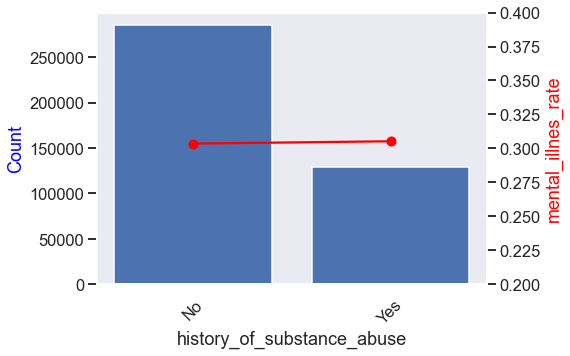

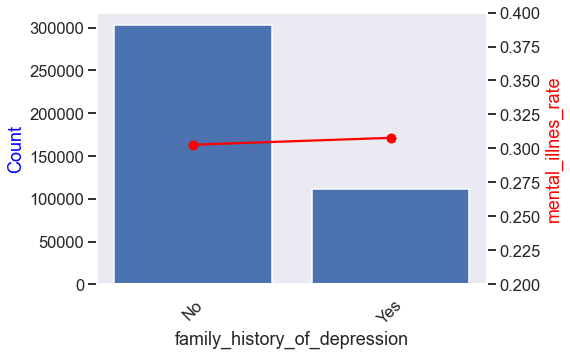

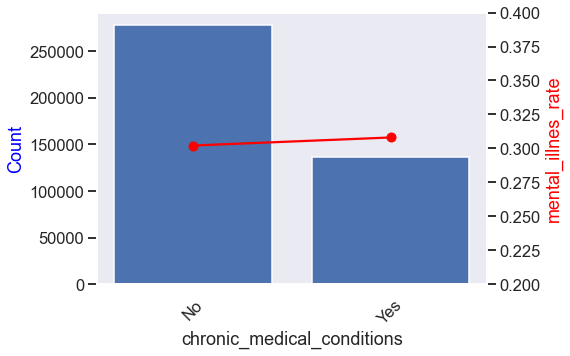

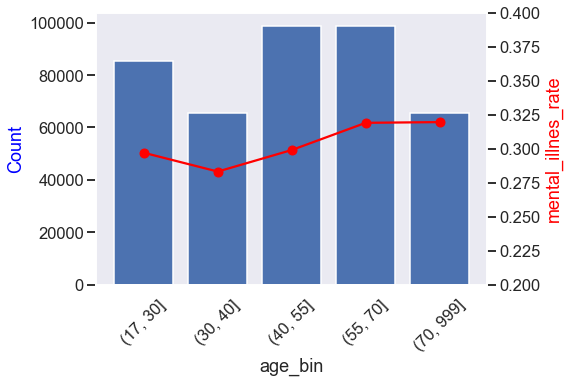

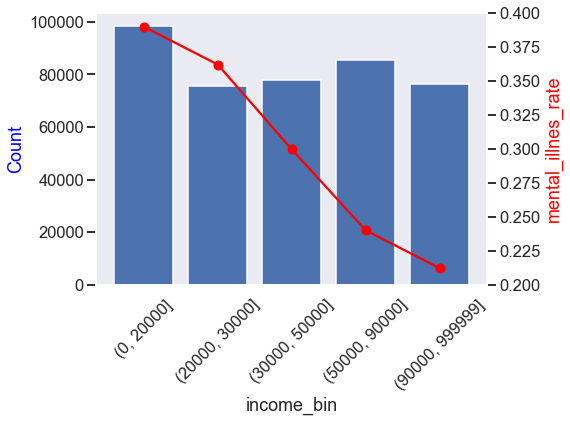

In [160]:
data["age_bin"] = pd.cut(data['age'], bins=[17, 30, 40, 55, 70, 999]).astype(str)
data["income_bin"] = pd.cut(data['income'], bins=[0, 20000, 30000, 50000, 90000, 999999]).astype(str)
cat_vars = ['marital_status', 'education_level', 'number_of_children'
       , 'smoking_status', 'physical_activity_level',
       'employment_status', 'alcohol_consumption', 'dietary_habits',
       'sleep_patterns', 'history_of_substance_abuse', 'family_history_of_depression',
       'chronic_medical_conditions', "age_bin", "income_bin"]
num_vars = ['age', 'income']

# here we explore each categorical variables distribution and also if there is any correlation with the outcome variable at face value
for col in cat_vars:
    categorical_plot(col)

## Modelling

In [51]:
X = data[['age', 'marital_status', 'education_level',
       'number_of_children', 'smoking_status', 'physical_activity_level',
       'employment_status', 'income', 'alcohol_consumption', 'dietary_habits',
       'sleep_patterns', 'history_of_substance_abuse', 'family_history_of_depression',
       'chronic_medical_conditions']] 
y = data["mental_illness"]  

## Random forests

In [52]:
ordinal_vars = ['marital_status', 'education_level',
       'smoking_status', 'physical_activity_level',
       'employment_status', 'alcohol_consumption', 'dietary_habits',
       'sleep_patterns', 'history_of_substance_abuse', 'family_history_of_depression',
       'chronic_medical_conditions']

In [75]:
# encoding ordinal/categorical variables for use in random forests
mapping_dict = [
    {"col": "marital_status", "mapping": {
        "Single" : 0,
        "Married" : 1,
        "Widowed" : 2,
        "Divorced" : 3
    }},
    {"col": "education_level", "mapping": {
        '''Bachelor's Degree''': 2,
        'High School': 0,
        'Associate Degree': 1,  
        '''Master\'s Degree''': 3,   
        'PhD': 4 
    }},
    {"col": "smoking_status", "mapping": {
        'Non-smoker': 0,   
        'Former': 1,     
        'Current': 2
    }},
    {"col": "physical_activity_level", "mapping": {
        'Sedentary': 0,   
        'Moderate': 1,     
        'Active': 2
    }},
    {"col": "employment_status", "mapping": {
        'Unemployed': 0,   
        'Employed': 1,     
        'Active': 2
    }},
    {"col": "alcohol_consumption", "mapping": {
        'Low': 0,   
        'Moderate': 1,     
        'High': 2
    }},
    {"col": "dietary_habits", "mapping": {
        'Unhealthy': 2,   
        'Moderate': 1,   
        'Healthy': 0
    }},
    {"col": "sleep_patterns", "mapping": {
        'Poor': 0,   
        'Fair': 1,   
        'Good': 2
    }},
    {"col": "history_of_substance_abuse", "mapping": {
        "Yes" : 1,
        "No" : 0
    }},
    {"col": "family_history_of_depression", "mapping": {
        "Yes" : 1,
        "No" : 0
    }},
    {"col": "chronic_medical_conditions", "mapping": {
        "Yes" : 1,
        "No" : 0
    }}
]
encoder = ce.OrdinalEncoder(mapping=mapping_dict)

In [76]:
X_encoded = encoder.fit_transform(X)
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_encoded, y, test_size=0.2, random_state=42) # train test split

In [136]:
rf = RandomForestClassifier(criterion="gini", random_state=42)

# training the model with a simple grid search to do a basic optimisation of parameters
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [5, 10, 20],
    'min_samples_split': [100, 200, 500],
    'max_features': [0.75]
}
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=4, scoring='accuracy', n_jobs=-1, verbose=2)

grid_search.fit(X_train_rf, y_train_rf)
print(f"Best parameters: {grid_search.best_params_}")

Fitting 4 folds for each of 18 candidates, totalling 72 fits
Best parameters: {'max_depth': 10, 'max_features': 0.5, 'min_samples_split': 100, 'n_estimators': 300}


In [140]:
y_test_pred_prob = grid_search.best_estimator_.predict_proba(X_test_rf)[:, 1]
y_test_pred = y_test_pred_prob > 0.3

print(f'Test Accuracy: {accuracy_score(y_test_rf, y_test_pred):.2f}')
print(f'Test Classification Report:\n{classification_report(y_test_rf, y_test_pred)}')
print(f'Test confusion matrix:\n{confusion_matrix(y_test_rf, y_test_pred)}')
print(f'Test roc_auc_score: {roc_auc_score(y_test_rf, y_test_pred_prob):3f}')

Test Accuracy: 0.56
Test Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.49      0.58     57671
           1       0.30      0.50      0.38     25083

    accuracy                           0.50     82754
   macro avg       0.50      0.50      0.48     82754
weighted avg       0.58      0.50      0.52     82754

Test confusion matrix:
[[30888 26583]
 [10024 15259]]
Test roc_auc_score: 0.599846


<AxesSubplot: ylabel='feature'>

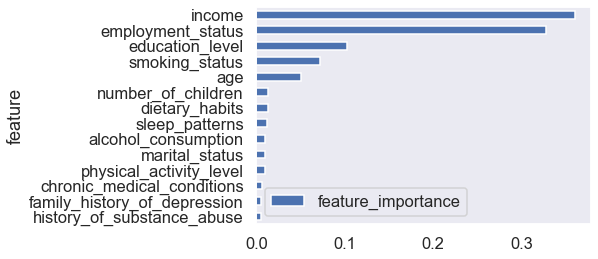

In [155]:
# we use the built in feature importance to see which features the random forests classifier values most
pd.DataFrame({"feature": grid_search.best_estimator_.feature_names_in_, "feature_importance": grid_search.best_estimator_.feature_importances_})\
    .sort_values("feature_importance")\
    .set_index("feature")\
    .plot(kind="barh")